In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans

# Gaussian Mixture Class

In [2]:
class GMM():
    def __init__(self, k, initialization='kmean'):
        self.k = k
        self.initialization = initialization
        self.data = None

    def _register_data(self, data):
        self.data = data
        self.n, self.d = data.shape
        
        # centers/means init
        if self.initialization == 'kmean':
            kmeans = KMeans(n_clusters=self.k, random_state=0, max_iter=1, tol=1, algorithm='elkan').fit(self.data)
            self.mean = np.array(kmeans.cluster_centers_)
        else:
            idx = np.random.randint(self.n, size=self.k)
            self.mean = np.array(self.data[idx,:])
        self.mean_trace = np.expand_dims(self.mean, -1)
        
        # affectation
        self.cluster = np.zeros(self.n)

        # responsabilities
        self.resp = np.zeros((self.n, self.k))
        self.N = self.resp.sum()
        
        # covariances
        self.cov = np.array([np.identity(self.d)]*self.k)

        # mixture weights
        self.pi = [1/self.k]*self.k

    def e_step(self):
        pdf = np.zeros((self.n, self.k))
        for j in range(self.k):
            pdf[:, j] = mvn.pdf(self.data, mean=self.mean[j], cov=self.cov[j])
        
        tot = pdf.sum(1)
        for j in range(self.k):
            self.resp[:, j] = self.pi[j] * pdf[:, j] / tot
    
        self.N = self.resp.sum()
        self.cluster = np.argmax(self.resp, axis=1)

    def m_step(self):
        nk = self.resp.sum(0)
        for j in range(self.k):
            nj = nk[j]

            # update mean
            muj = 1 / nj * self.resp[:, j].T.dot(self.data)
            self.mean[j] = muj

            # update cov
            centered = self.data - self.mean[j]
            outer = np.expand_dims(centered, -1) * np.expand_dims(centered, -2)
            wouter = self.resp[:, j].reshape(-1,1,1) * outer
            sigmaj = wouter.sum(0) / nj
            
            self.cov[j] = sigmaj
            self.pi[j] = nj / self.N

    def fit(self, data, iter=10):
        if self.data is None:
            self._register_data(data)
            
        for i in range(iter):
            self.e_step()
            self.m_step()
            self.mean_trace = np.concatenate((self.mean_trace, np.expand_dims(self.mean, -1)), 2)
        self.e_step()
        return self

# Create Data

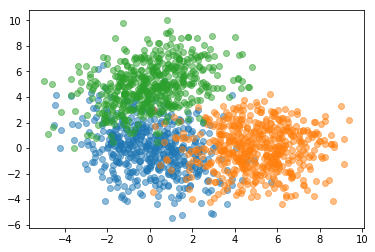

In [3]:
m1 = np.array([0, 0])
m2 = np.array([5, 0])
m3 = np.array([0, 5])

v1 = np.array([[3, -1], [-1, 4]])
v2 = np.array([[3, 0], [0, 3]])
v3 = np.array([[3, 1], [1, 3]])

x1, y1 = np.random.multivariate_normal(m1, v1, 500).T
x2, y2 = np.random.multivariate_normal(m2, v2, 500).T
x3, y3 = np.random.multivariate_normal(m3, v3, 500).T

x = np.array([x1, x2, x3]).flatten()
y = np.array([y1, y2, y3]).flatten()
data = np.array([x, y]).T

plt.plot(x1, y1,'o', alpha=0.5)
plt.plot(x2, y2, 'o', alpha=0.5)
plt.plot(x3, y3, 'o', alpha=0.5)
plt.show()

# Initialize Model

In [4]:
model = GMM(3, initialization='')

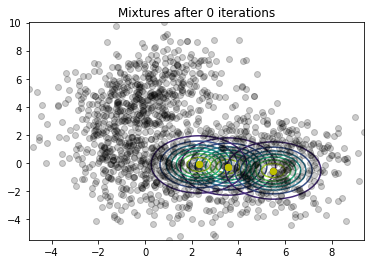

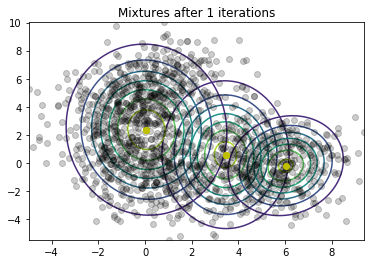

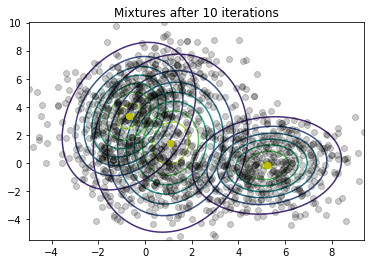

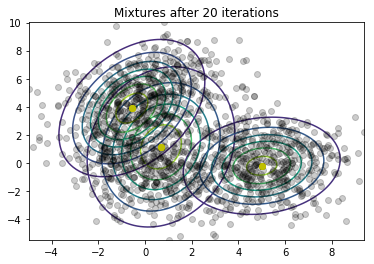

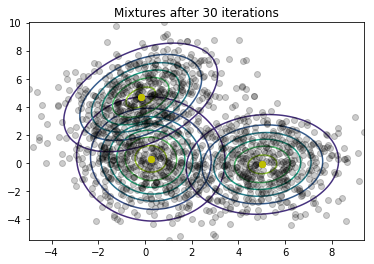

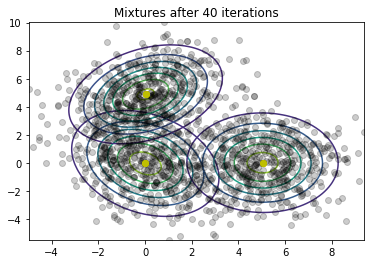

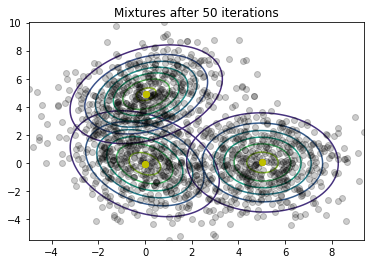

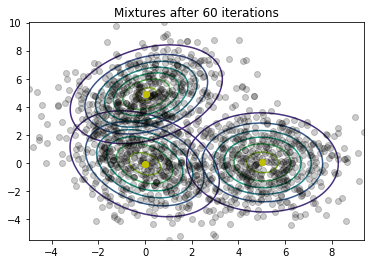

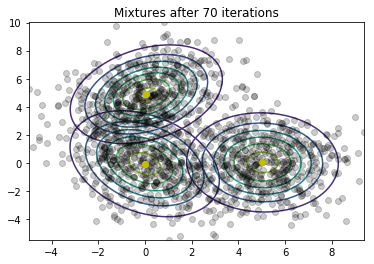

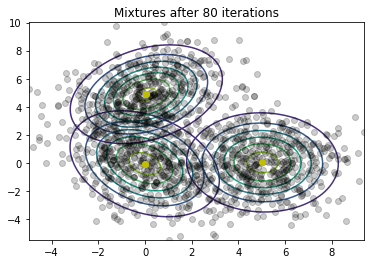

In [5]:
it = 0
for i in [0, 1, 9, 10, 10, 10, 10, 10, 10, 10]:
    it += i
    model = model.fit(data, i)
    # plot mixtures
    xmin, xmax = min(model.data[:,0]), max(model.data[:,0])
    ymin, ymax = min(model.data[:,1]), max(model.data[:,1])
    for c in range(model.k):
        plt.plot(model.data[model.cluster==c][:,0], model.data[model.cluster==c][:,1], 'o', color='k', alpha=0.2)
        plt.plot(model.mean[:,0], model.mean[:,1], 'o', color='y')
        x, y = np.meshgrid(np.linspace(xmin,xmax,100),np.linspace(ymin,ymax,100))
        xy = np.column_stack([x.flat, y.flat])
        mu = model.mean[c]
        cov = model.cov[c]
        z = mvn.pdf(xy, mu, cov).reshape(x.shape)
        plt.contour(x, y, z)
        plt.title('Mixtures after {} iterations'.format(it))
    plt.show()

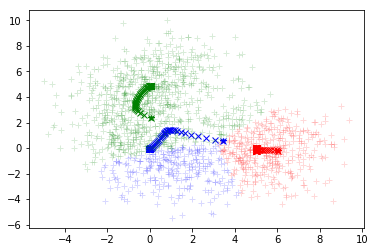

In [6]:
# plot means trace
clist = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for c in range(model.k):
    plt.plot(model.data[model.cluster==c][:,0], model.data[model.cluster==c][:,1], '+', color=clist[c], alpha=0.15)
    plt.plot(model.mean_trace[c,0,0], model.mean_trace[c,1,0], '*', color=clist[c])
    plt.plot(model.mean_trace[c,0,1:-1], model.mean_trace[c,1,1:-1], 'x', color=clist[c])
    plt.plot(model.mean_trace[c,0,-1], model.mean_trace[c,1,-1], 'o', color=clist[c])